In [1]:
import mxnet as mx 
from symbol import get_resnet_model
from symbol import YOLO_loss
from data_ulti import get_iterator
import matplotlib.pyplot as plt 
import cv2
import matplotlib.patches as patches
import numpy as np

In [2]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    return [cxt, cyt, wt, ht]

def bboxdraw(img, label, dscale=32):
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0]>0.1)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(np.uint8(img))
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h = label[i,j,1:]
        cxt, cyt, wt ,ht = decodeBox([i, j, cx,cy,w,h], size, dscale)
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    
        plt.plot(int(cxt), int(cyt), '*')
    plt.show()

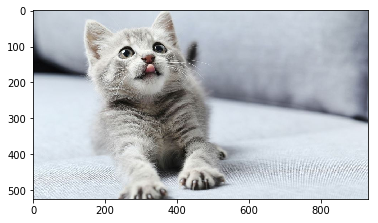

Orignal Cat


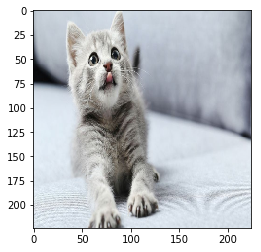

Resize Cat


In [3]:
cat = plt.imread("cat.jpg")
plt.imshow(cat)
plt.show()
print ("Orignal Cat")
W = 224
H = 224
cat_resize = cv2.resize(cat, (H,W))
plt.imshow(cat_resize)
plt.show()
print ("Resize Cat")

cat_nd = mx.nd.array(ctx=mx.gpu(0), source_array=cat_resize.transpose((2,0,1)).reshape(1,3,H,W))
cat_itr = mx.io.NDArrayIter(data=cat_nd, data_name='data',  batch_size=1)


In [11]:
sym, args_params, aux_params = mx.model.load_checkpoint('cat_detect_full_scale', 588)
logit = sym.get_internals()['logit_output']
mod = mx.mod.Module(symbol=logit, context=mx.gpu(0))
mod.bind(cat_itr.provide_data)
mod.init_params(allow_missing=False, arg_params=args_params, aux_params=aux_params, 
                initializer=mx.init.Xavier(magnitude=2,rnd_type='gaussian',factor_type='in'))
out = mod.predict(eval_data=cat_itr, num_batch=10)

/usr/local/lib/python3.5/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python3.5/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [12]:
out


[[[[-0.9863801   0.3055346  -0.7976267  -0.9040453  -0.88821036]
   [-0.9862305   0.67547023 -0.5640911  -0.72898746 -0.77103174]
   [-0.9815508   0.6351489  -0.4841256  -0.52162427 -0.712514  ]
   [-0.9805131   0.15684876 -0.81783956 -0.584037   -0.73760015]
   [-0.9849803   0.19359092 -0.7489285  -0.7628215  -0.8104517 ]
   [-0.98872155 -0.14094774 -0.40023315 -0.7198319  -0.8422905 ]
   [-0.9863535  -0.6066778  -0.5820337  -0.8128398  -0.88125193]]

  [[-0.985608   -0.9078849   0.5222075  -0.9069038  -0.8897738 ]
   [-0.98586684  0.6028873  -0.17075528 -0.3777358  -0.45695817]
   [-0.9829078  -0.6448219  -0.46587554 -0.6784805  -0.6002148 ]
   [-0.978572   -0.79689646  0.10712186 -0.6138873  -0.6912081 ]
   [-0.985436    0.41566202  0.4753055  -0.745992   -0.7557356 ]
   [-0.9884667  -0.90551287 -0.5918567  -0.8459494  -0.83167964]
   [-0.98703367 -0.5175747  -0.6495856  -0.8805741  -0.88196516]]

  [[-0.97644514 -0.7390903   0.7418634  -0.8811576  -0.8580452 ]
   [-0.97865903  0.6

In [13]:
#pred->softsing->x/(1+abs(x))
pred = (out.asnumpy()[0]+1)/2
print (pred)

[[[0.00680995 0.6527673  0.10118666 0.04797736 0.05589482]
  [0.00688475 0.8377351  0.21795446 0.13550627 0.11448413]
  [0.00922459 0.81757444 0.2579372  0.23918787 0.14374301]
  [0.00974345 0.5784244  0.09108022 0.2079815  0.13119993]
  [0.00750986 0.59679544 0.12553576 0.11858925 0.09477416]
  [0.00563923 0.42952612 0.29988343 0.14008406 0.07885474]
  [0.00682324 0.19666111 0.20898315 0.0935801  0.05937403]]

 [[0.00719601 0.04605755 0.76110375 0.0465481  0.05511311]
  [0.00706658 0.80144364 0.41462237 0.3111321  0.2715209 ]
  [0.00854611 0.17758906 0.26706225 0.16075975 0.19989261]
  [0.01071399 0.10155177 0.5535609  0.19305634 0.15439594]
  [0.00728199 0.707831   0.7376528  0.127004   0.12213221]
  [0.00576666 0.04724357 0.20407164 0.07702529 0.08416018]
  [0.00648317 0.24121264 0.1752072  0.05971295 0.05901742]]

 [[0.01177743 0.13045484 0.87093174 0.05942121 0.07097739]
  [0.01067048 0.8283835  0.8472973  0.7137867  0.73018056]
  [0.0212954  0.68291795 0.5265569  0.3454411  0.556

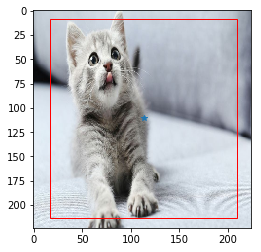

In [14]:
bboxdraw(cat_resize, pred)